In [151]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro, probplot

In [14]:
SEED = 1234
USER = "victor"
PATH = os.path.join(os.path.sep, "home", USER, ".kaggle", "house-prices-advanced-regression-techniques")
sns.set(style="white")

In [15]:
def load_data():
    train_path = os.path.join(PATH, 'train.csv')
    test_path = os.path.join(PATH, 'test.csv')

    train_df = pd.read_csv(train_path, parse_dates=True, encoding='UTF-8')
    test_df = pd.read_csv(test_path, parse_dates=True, encoding='UTF-8')

    return train_df, test_df

### 1. Correlation Matrix

In [16]:
train_df, test_df = load_data()

In [17]:
def get_correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()
    min_value = corr.min().min()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=min_value, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .3})

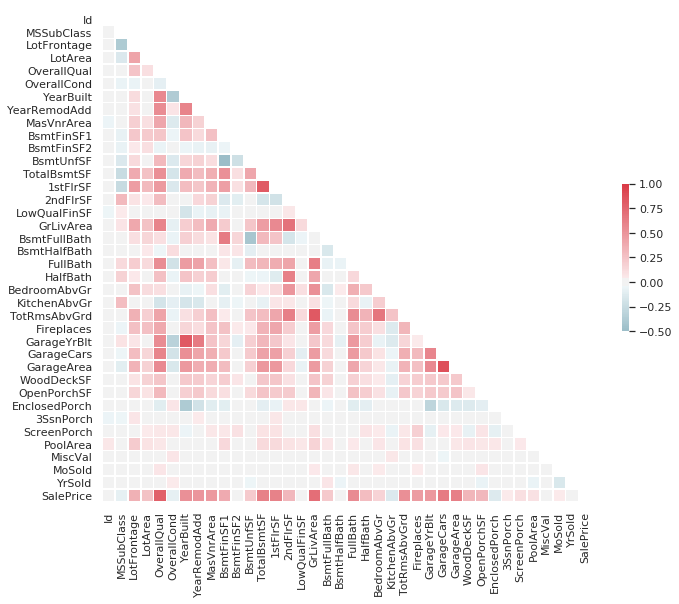

In [18]:
get_correlation_matrix(train_df)

In [19]:
def get_top_correlation_variables(df, threshold=0.5, ascending=False):
    c = df.corr().abs()
    s = c.unstack()
    top_corr = s.sort_values(kind="quicksort", ascending=ascending)
    top_corr = top_corr[top_corr != 1]
    top_corr = top_corr.drop_duplicates()
    return top_corr[top_corr > threshold]


In [20]:
get_top_correlation_variables(train_df)

GarageCars    GarageArea      0.882475
GarageYrBlt   YearBuilt       0.825667
GrLivArea     TotRmsAbvGrd    0.825489
1stFlrSF      TotalBsmtSF     0.819530
OverallQual   SalePrice       0.790982
GrLivArea     SalePrice       0.708624
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFullBath  BsmtFinSF1      0.649212
GarageYrBlt   YearRemodAdd    0.642277
SalePrice     GarageCars      0.640409
FullBath      GrLivArea       0.630012
SalePrice     GarageArea      0.623431
2ndFlrSF      TotRmsAbvGrd    0.616423
SalePrice     TotalBsmtSF     0.613581
HalfBath      2ndFlrSF        0.609707
1stFlrSF      SalePrice       0.605852
OverallQual   GarageCars      0.600671
GrLivArea     OverallQual     0.593007
YearBuilt     YearRemodAdd    0.592855
GarageCars    GarageYrBlt     0.588920
OverallQual   YearBuilt       0.572323
1stFlrSF      GrLivArea       0.566024
GarageArea    GarageYrBlt     0.564567
              OverallQual     0.562022
SalePrice     FullBath   

### 2. Visualization EDA

In [42]:
train_df['SalePrice'].mean()

180921.19589041095

In [132]:
def plot_target_histogram(y, num_bins=50, name='target'):
    fig, ax = plt.subplots(figsize=(12,9))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.hist(y, num_bins, weights=np.zeros_like(train_df.SalePrice) + 1. / train_df.SalePrice.size, facecolor='blue', alpha=0.7)
    ax.xaxis.set_major_locator(MaxNLocator(25))
    ax.yaxis.set_major_locator(MaxNLocator(25))
    plt.ylabel('% Frequency')
    plt.xlabel('$ Price in 1e5')
    # plt.hist(np.log1p(y), bins=num_bins, facecolor='blue', alpha=0.7)
    plt.axvline(train_df['SalePrice'].mean(), color='g')
    plt.axvline(train_df['SalePrice'].quantile(0.25), color='r')
    plt.axvline(train_df['SalePrice'].median(), color='r')
    plt.axvline(train_df['SalePrice'].quantile(0.75), color='r')
    plt.legend(['Mean', 'Percentiles 25, 50, 75'], prop={'size': 15})
    plt.show()

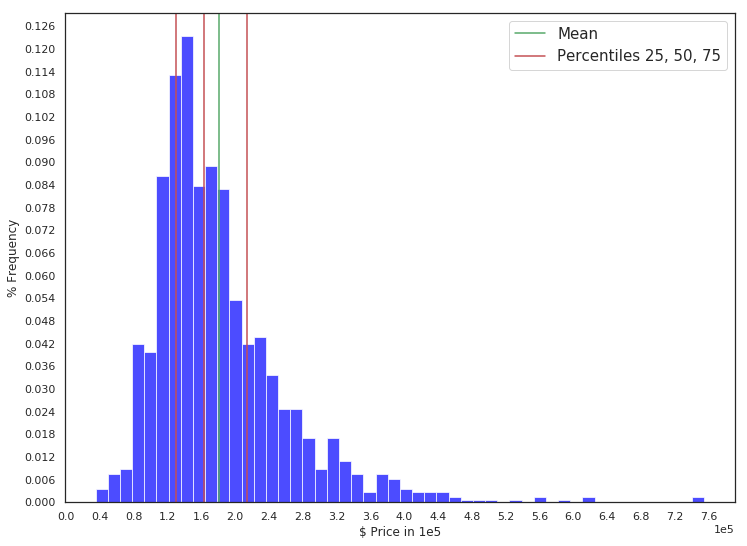

In [133]:
plot_target_histogram(train_df['SalePrice'])

In [136]:
# Falta de simetria o asimétrica -> Mayor asimetria con respecto a la media por la derecha ya que el valor es positiv
skew(train_df['SalePrice'])

1.880940746034036

In [137]:
# Curtosis -> leptocúrtica: más apuntada y con colas menos gruesas que la normal.
kurtosis(train_df['SalePrice'])

6.509812011089439

In [149]:
# Saphiro wilk test -> Test de normalidad to small sets
shapiro(train_df['SalePrice'])
# First value -> Statistic test is proximate to 1. 
# Second value -> p value which don't allow to refuse null hypothesis

(0.869671642780304, 3.206247534576162e-33)

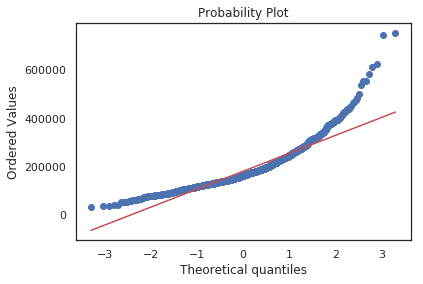

In [160]:
# qqplot -> No sigue una distribución muy normal
fig = plt.figure()
probplot(train_df['SalePrice'], plot=plt)
plt.show()

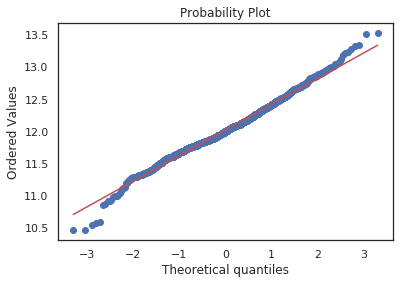

In [162]:
# log qqplot
fig = plt.figure()
probplot(np.log1p(train_df['SalePrice']), plot=plt)
plt.show()